In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 29 09:45:42 2017

@author: pierr
"""
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [2]:
#IMPORTATION DES DONNEES
df_origin= pd.read_csv('all_data_v1_1_infos_iris.csv', delimiter=',')
df_origin_position= df_origin[['lon','lat']]

In [3]:
#INDEXATION PAR LE CODE IRIS
tags = ['id_iris','c_elec_conso_tot_res',
       'c_elec_conso_tot_agr', 'c_elec_conso_tot_indus',
       'c_elec_conso_tot_tert', 'p_elec_prod_pv',
       'p_elec_prod_eol','p_elec_prod_bio','p_elec_prod_coge']
df_origin_group=df_origin.groupby(['id_iris'])
#df_origin_group1=df_origin_group.get_group('100150000')

tags2 = ['c_elec_conso_tot_res',
       'c_elec_conso_tot_agr', 'c_elec_conso_tot_indus',
       'c_elec_conso_tot_tert', 'p_elec_prod_pv',
       'p_elec_prod_eol','p_elec_prod_bio','p_elec_prod_coge']
tags3=[s+'_par_hbts' for s in tags2]
test=df_origin[tags2].values/df_origin[['socioeco_npers']].values
df_origin[tags3]=pd.DataFrame(test)

tags3.append('id_iris')
df_origin=df_origin[tags3]
df_origin=df_origin.set_index(['id_iris'])

In [4]:
#REMPLISSAGE DES CASES VIDES PAR DES 0
df_woNan=df_origin.fillna(0)

In [5]:
#REDUCTION DE DIMENSION POUR VISUALISATION
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True) 

In [6]:
import time
start_time = time.time()
#LIMITATION DU NOMBRE DE SAMPLES
nb_samples=1000#len(df_woNan.index)
nb_clusters=10

import random
random_idx=random.sample(range(len(df_woNan.index)), nb_samples)
#random_idx=np.array(range(len(df_woNan.index)))

In [7]:
#CLUSTERISATION HIERARCHIQUE
from sklearn.cluster import AgglomerativeClustering
hierarch_cluster=AgglomerativeClustering(n_clusters=nb_clusters)
cluster_nmb= np.zeros(shape=(nb_samples,1))
cluster_nmb=hierarch_cluster.fit_predict(df_woNan.iloc[random_idx], y=cluster_nmb)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.596997022629 seconds ---


In [8]:
ndarray_tsne=model.fit_transform(df_woNan.iloc[random_idx]) 

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


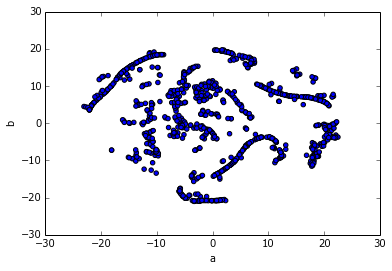

In [9]:
##PLOT EN 2D PRE-CLUSTER
df_tsne=pd.DataFrame(ndarray_tsne,columns=['a', 'b'])
df_tsne.plot.scatter(x='a', y='b');
#

ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


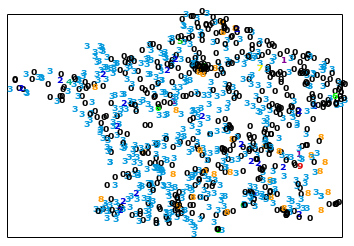

In [10]:
##PLOT EN 2D POST-CLUSTER
from matplotlib import pyplot as plt
def plot_clustering(X_red, y,labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('on')
    plt.show()
plot_clustering(df_tsne.as_matrix(), hierarch_cluster.labels_, hierarch_cluster.labels_, "Clusters énergétiques en France")

df_origin_position_small=df_origin_position.ix[random_idx]
plot_clustering(df_origin_position_small.as_matrix(), cluster_nmb,cluster_nmb, title=None)
#pyplot.scatter(df_origin_position[['lon']].ix[random_idx].as_matrix(), df_origin_position[['lat']].ix[random_idx].as_matrix(), c=hierarch_cluster.labels_)
#pyplot.show()

In [11]:
#AJOUT DU NUMERO DU CLUSTER
df_woNan_selec=df_woNan.ix[random_idx]
df_woNan_selec['cluster']=hierarch_cluster.labels_

#indicestest=pd.DataFrame(indices).loc[:1000].applymap(lambda x:df_positionIRIS.ix[x,['INSEE COMM']].valu)


#output=df_woNan[['id_iris']]
#output['Classe']=cluster_nmb
#output.to_csv('IRIS_10classes_ecoseulmnt.csv', sep=';', index=False)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


In [12]:

#STATISTIQUES PAR CLUSTER
df_woNan_selec_group=df_woNan_selec.groupby('cluster')
df_woNan_selec_stats=df_woNan_selec_group.mean()

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(df_woNan)
distances, indices = nbrs.kneighbors(df_woNan)

